## Load snli train and val data

In [1]:
import pandas as pd

# load snli train data
snli_train = pd.read_csv("snli_train.tsv", sep='\t')
snli_train.loc[snli_train['label'] == 'neutral', 'y'] = 0
snli_train.loc[snli_train['label'] == 'entailment', 'y'] = 1
snli_train.loc[snli_train['label'] == 'contradiction', 'y'] = 2
train_s1 = snli_train['sentence1'].tolist()
train_s2 = snli_train['sentence2'].tolist()
train_label = snli_train['y'].tolist()

# load snli val data
snli_val = pd.read_csv("snli_val.tsv", sep='\t')
snli_val.loc[snli_val['label'] == 'neutral', 'y'] = 0
snli_val.loc[snli_val['label'] == 'entailment', 'y'] = 1
snli_val.loc[snli_val['label'] == 'contradiction', 'y'] = 2
val_s1 = snli_val['sentence1'].tolist()
val_s2 = snli_val['sentence2'].tolist()
val_label = snli_val['y'].tolist()

## Load the FastText embedding matrix and get the indices data

In [2]:
# First lets improve libraries that we are going to be used in this lab session
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
random.seed(134)

PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 128

In [3]:
# loading Fast text vectors
ft_home = './'
words_to_load = 50000

import numpy as np

with open(ft_home + 'wiki-news-300d-1M.vec') as f:
    loaded_embeddings = np.zeros((words_to_load + 1, 300))
    words2idx = {}
    idx2words = {}
    ordered_words = []
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings[i + 1, :] = np.asarray(s[1:])
        words2idx[s[0]] = i + 1
        idx2words[i+1] = s[0]
        ordered_words.append(s[0])
        
idx2words[PAD_IDX] = '<pad>'
idx2words[UNK_IDX] = '<unk>'
words2idx['<pad>'] = PAD_IDX
words2idx['<unk>'] = UNK_IDX
loaded_embeddings[PAD_IDX] = torch.zeros(300)
loaded_embeddings[UNK_IDX] = torch.randn(300)
pre_emb = torch.from_numpy(loaded_embeddings)
pre_emb = pre_emb.float()

In [4]:
# convert token to id in the dataset
def token2index_dataset(tokens_dataset):
    indices_data = []
    for tokens_data in tokens_dataset:
        tokens = tokens_data.split()
        index_list = [words2idx[token] if token in words2idx else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_s1_idx = token2index_dataset(train_s1)
train_s2_idx = token2index_dataset(train_s2)
val_s1_idx = token2index_dataset(val_s1)
val_s2_idx = token2index_dataset(val_s2)

## Process the data with data loader

In [5]:
MAX_SENTENCE_LENGTH = max([len(s) for s in train_s1_idx + train_s2_idx])

class VocabDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_list, target_list):
        """
        @param data_list: list of tokens
        @param target_list: list of targets

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        s1 = self.data_list[key][0][:MAX_SENTENCE_LENGTH]
        s2 = self.data_list[key][1][:MAX_SENTENCE_LENGTH]
        l1 = len(s1)
        l2 = len(s2)
        label = self.target_list[key]
        return [[s1, s2], [l1, l2], label]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []

    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_s1 = np.pad(np.array(datum[0][0]),
                            pad_width=((0,MAX_SENTENCE_LENGTH-datum[1][0])),
                            mode="constant", constant_values=0)
        padded_s2 = np.pad(np.array(datum[0][1]),
                            pad_width=((0,MAX_SENTENCE_LENGTH-datum[1][1])),
                            mode="constant", constant_values=0)
        padded_vec = [padded_s1, padded_s2]
        data_list.append(padded_vec)
#     ind_dec_order = np.argsort(length_list)[::-1]
#     data_list = np.array(data_list)[ind_dec_order]
#     length_list = np.array(length_list)[ind_dec_order]
#     label_list = np.array(label_list)[ind_dec_order]
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]


In [6]:
train_data = np.array([train_s1_idx, train_s2_idx]).transpose()
val_data = np.array([val_s1_idx, val_s2_idx]).transpose()

train_dataset = VocabDataset(train_data, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           collate_fn=vocab_collate_func, 
                                           shuffle=True)
val_dataset = VocabDataset(val_data, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=BATCH_SIZE, 
                                         collate_fn=vocab_collate_func, 
                                         shuffle=True)

## Encode the data with CNN

In [7]:
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_classes, vocab_size):

        super(CNN, self).__init__()

        self.hidden_size = hidden_size
        # Use pre-trained embedding matrix
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding.weight = nn.Parameter(pre_emb)
        self.embedding.weight.requires_grad = False
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        
        self.maxpool = nn.MaxPool1d(kernel_size=MAX_SENTENCE_LENGTH)
        
        self.fc1 = nn.Linear(2 * hidden_size, hidden_size)        
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, data, length):        
        
        data = data.transpose(0,1)
        
        embed1 = self.embedding(data[0]).transpose(1,2)
        
        s1 = self.conv1(embed1)
        s1 = F.relu(s1.contiguous())
        
        s1 = self.conv2(s1)
        s1 = F.relu(s1.contiguous())
        
        s1 = self.maxpool(s1)
        
        embed2 = self.embedding(data[1]).transpose(1,2)
        
        s2 = self.conv1(embed2)
        s2 = F.relu(s2.contiguous())

        s2 = self.conv2(s2)
        s2 = F.relu(s2.contiguous())
        
        s2 = self.maxpool(s2)
        
        x = torch.cat((s1,s2), dim=1).view(-1, 2 * self.hidden_size)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [8]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for (data, lengths, labels) in loader:
        
        outputs = F.softmax(model(data, lengths), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

def train_model(train_loader, val_loader, model):
    train_acc_list = []
    val_acc_list = []

    # Train the model
    for epoch in range(num_epochs):
        for i, (data, length, label) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()

            # Forward pass
            outputs = model(data, length)
            loss = criterion(outputs, label)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                train_acc = test_model(train_loader, model)
                val_acc = test_model(val_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Training Acc: {}, Validation Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc))
                train_acc_list.append(train_acc)
                val_acc_list.append(val_acc)
    return train_acc_list, val_acc_list

model1 = CNN(emb_size=300, hidden_size=200, num_classes=3, vocab_size=len(idx2words))

learning_rate = 3e-4
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)

train_acc1, val_acc1 = train_model(train_loader, val_loader, model1)

Epoch: [1/10], Step: [101/782], Training Acc: 50.312, Validation Acc: 48.8
Epoch: [1/10], Step: [201/782], Training Acc: 57.347, Validation Acc: 56.7
Epoch: [1/10], Step: [301/782], Training Acc: 60.094, Validation Acc: 60.6
Epoch: [1/10], Step: [401/782], Training Acc: 61.869, Validation Acc: 60.6
Epoch: [1/10], Step: [501/782], Training Acc: 62.343, Validation Acc: 61.2
Epoch: [1/10], Step: [601/782], Training Acc: 61.963, Validation Acc: 60.6
Epoch: [1/10], Step: [701/782], Training Acc: 63.625, Validation Acc: 62.7
Epoch: [2/10], Step: [101/782], Training Acc: 64.935, Validation Acc: 63.0
Epoch: [2/10], Step: [201/782], Training Acc: 64.661, Validation Acc: 62.7
Epoch: [2/10], Step: [301/782], Training Acc: 65.031, Validation Acc: 62.7
Epoch: [2/10], Step: [401/782], Training Acc: 65.385, Validation Acc: 63.1
Epoch: [2/10], Step: [501/782], Training Acc: 66.43, Validation Acc: 63.9
Epoch: [2/10], Step: [601/782], Training Acc: 66.506, Validation Acc: 63.3
Epoch: [2/10], Step: [701/

In [9]:
model2 = CNN(emb_size=300, hidden_size=100, num_classes=3, vocab_size=len(idx2words))

learning_rate = 3e-4
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

train_acc2, val_acc2 = train_model(train_loader, val_loader, model2)

Epoch: [1/10], Step: [101/782], Training Acc: 49.946, Validation Acc: 49.5
Epoch: [1/10], Step: [201/782], Training Acc: 56.141, Validation Acc: 55.4
Epoch: [1/10], Step: [301/782], Training Acc: 58.646, Validation Acc: 57.8
Epoch: [1/10], Step: [401/782], Training Acc: 60.24, Validation Acc: 59.4
Epoch: [1/10], Step: [501/782], Training Acc: 60.933, Validation Acc: 60.6
Epoch: [1/10], Step: [601/782], Training Acc: 61.672, Validation Acc: 60.7
Epoch: [1/10], Step: [701/782], Training Acc: 62.352, Validation Acc: 62.6
Epoch: [2/10], Step: [101/782], Training Acc: 63.06, Validation Acc: 61.4
Epoch: [2/10], Step: [201/782], Training Acc: 62.887, Validation Acc: 61.3
Epoch: [2/10], Step: [301/782], Training Acc: 63.742, Validation Acc: 61.7
Epoch: [2/10], Step: [401/782], Training Acc: 63.858, Validation Acc: 60.8
Epoch: [2/10], Step: [501/782], Training Acc: 64.289, Validation Acc: 62.3
Epoch: [2/10], Step: [601/782], Training Acc: 64.285, Validation Acc: 62.0
Epoch: [2/10], Step: [701/7

In [25]:
class CNN2(nn.Module):
    def __init__(self, emb_size, hidden_size, num_classes, vocab_size):

        super(CNN2, self).__init__()

        self.hidden_size = hidden_size
        # Use pre-trained embedding matrix
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding.weight = nn.Parameter(pre_emb)
        self.embedding.weight.requires_grad = False
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        
        self.maxpool = nn.MaxPool1d(kernel_size=MAX_SENTENCE_LENGTH)
        
        self.fc1 = nn.Linear(hidden_size, 100)        
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, data, length):        
        
        data = data.transpose(0,1)
        
        embed1 = self.embedding(data[0]).transpose(1,2)
        
        s1 = self.conv1(embed1)
        s1 = F.relu(s1.contiguous())
        
        s1 = self.conv2(s1)
        s1 = F.relu(s1.contiguous())
        
        s1 = self.maxpool(s1)
        
        embed2 = self.embedding(data[1]).transpose(1,2)
        
        s2 = self.conv1(embed2)
        s2 = F.relu(s2.contiguous())

        s2 = self.conv2(s2)
        s2 = F.relu(s2.contiguous())
        
        s2 = self.maxpool(s2)
        
        x = s1 * s2
        x = x.view(-1, self.hidden_size)

        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [26]:
model3 = CNN2(emb_size=300, hidden_size=200, num_classes=3, vocab_size=len(idx2words))

learning_rate = 3e-4
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate)

train_acc3, val_acc3 = train_model(train_loader, val_loader, model3)

Epoch: [1/10], Step: [101/782], Training Acc: 33.821, Validation Acc: 33.4
Epoch: [1/10], Step: [201/782], Training Acc: 47.548, Validation Acc: 46.9
Epoch: [1/10], Step: [301/782], Training Acc: 51.987, Validation Acc: 52.4
Epoch: [1/10], Step: [401/782], Training Acc: 53.348, Validation Acc: 53.8
Epoch: [1/10], Step: [501/782], Training Acc: 53.715, Validation Acc: 52.1
Epoch: [1/10], Step: [601/782], Training Acc: 54.522, Validation Acc: 54.0
Epoch: [1/10], Step: [701/782], Training Acc: 56.334, Validation Acc: 55.0
Epoch: [2/10], Step: [101/782], Training Acc: 55.054, Validation Acc: 54.5
Epoch: [2/10], Step: [201/782], Training Acc: 57.005, Validation Acc: 54.7
Epoch: [2/10], Step: [301/782], Training Acc: 57.385, Validation Acc: 56.2
Epoch: [2/10], Step: [401/782], Training Acc: 58.88, Validation Acc: 56.9
Epoch: [2/10], Step: [501/782], Training Acc: 58.826, Validation Acc: 55.6
Epoch: [2/10], Step: [601/782], Training Acc: 59.632, Validation Acc: 58.3
Epoch: [2/10], Step: [701/

In [28]:
# print number of parameters in each CNN model
print("numer of parameters in model 1 is {}". format(sum(p.numel() for p in model1.parameters() if p.requires_grad)))
print("numer of parameters in model 2 is {}". format(sum(p.numel() for p in model2.parameters() if p.requires_grad)))
print("numer of parameters in model 3 is {}". format(sum(p.numel() for p in model3.parameters() if p.requires_grad)))


numer of parameters in model 1 is 381203
numer of parameters in model 2 is 140603
numer of parameters in model 3 is 320803


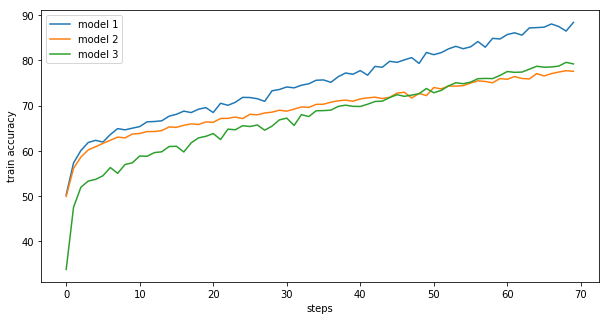

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
fig.set_size_inches(10,5)

plt.plot(train_acc1, label="model 1")
plt.plot(train_acc2, label="model 2")
plt.plot(train_acc3, label="model 3")
plt.xlabel("steps")
plt.ylabel("train accuracy")
plt.legend(loc = 'best')
plt.show()

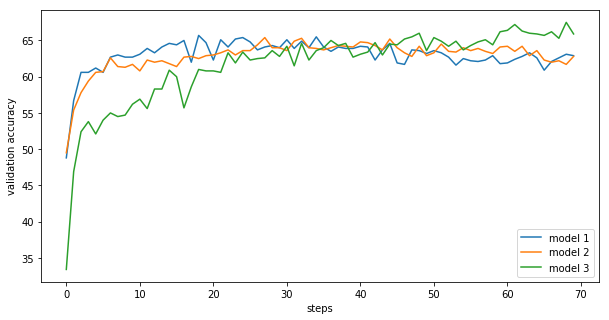

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
fig.set_size_inches(10,5)

plt.plot(val_acc1, label="model 1")
plt.plot(val_acc2, label="model 2")
plt.plot(val_acc3, label="model 3")
plt.xlabel("steps")
plt.ylabel("validation accuracy")
plt.legend(loc = 'best')
plt.show()

In [35]:
# Get the 3 incorrect predictions and 3 correct predictions

BATCH_SIZE = 1
val_dataset2 = VocabDataset(val_data, val_label)
val_loader2 = torch.utils.data.DataLoader(dataset=val_dataset2, 
                                         batch_size=BATCH_SIZE, 
                                         collate_fn=vocab_collate_func, 
                                         shuffle=True)

y2label = {0:'neutral', 1:'entailment', 2:'contradiction'}

def get_incorrect(loader, model):
    correct = 0
    total = 0
    model.eval()
    i = 0
    incorr_data = []
    for data, lengths, labels in loader:
        if i < 3:
            outputs = F.softmax(model(data, lengths), dim=1)
            predicted = outputs.max(1, keepdim=True)[1]
            
            if predicted.eq(labels.view_as(predicted)).sum().item() == 0:                
                i += 1
                for t in data[0]:
                    s = ''
                    for w in t:
                        if w == 0: break
                        w = w.item()
                        s += idx2words[w] + ' '
                    print(s)
                print("The predicted label is {}".format(y2label[predicted.item()]))
                print("The true label is {}".format(y2label[labels.view_as(predicted).item()]))
                print()
    return

print("Get 3 incorrect predictions: ")
get_incorrect(val_loader2, model3)

def get_correct(loader, model):
    correct = 0
    total = 0
    model.eval()
    i = 0
    incorr_data = []
    for data, lengths, labels in loader:
        if i < 3:
            outputs = F.softmax(model(data, lengths), dim=1)
            predicted = outputs.max(1, keepdim=True)[1]
            
            if predicted.eq(labels.view_as(predicted)).sum().item() == 1:                
                i += 1
                for t in data[0]:
                    s = ''
                    for w in t:
                        if w == 0: break
                        w = w.item()
                        s += idx2words[w] + ' '
                    print(s)
                print("The label is {}".format(y2label[predicted.item()]))
                print()
    return

print("Get 3 correct predictions: ")
get_correct(val_loader2, model3)

Get 3 incorrect predictions: 
The player from the black team is telling something to the player of the red team . 
The two teams are relaxing before the match . 
The predicted label is contradiction
The true label is neutral

A man doing maintenance on the railroad tracks 
There is an older man doing work on the railroad tracks . 
The predicted label is entailment
The true label is neutral

A horse and rider on a <unk> course . 
Three horses are playing in a field together . 
The predicted label is entailment
The true label is contradiction

Get 3 correct predictions: 
Man and a woman walking on the street 
There are at least two people in the picture . 
The label is entailment

A young girl is swimming in a pool . 
The girl is practicing for a swim meet . 
The label is neutral

A swimming dog with a small branch in its mouth . 
A dog is ice skating . 
The label is contradiction



## Test with mnli data

In [36]:
# load mnli val data
mnli_val = pd.read_csv("mnli_val.tsv", sep='\t')
mnli_val.loc[mnli_val['label'] == 'neutral', 'y'] = 0
mnli_val.loc[mnli_val['label'] == 'entailment', 'y'] = 1
mnli_val.loc[mnli_val['label'] == 'contradiction', 'y'] = 2
mnli_val.head()

,sentence1,sentence2,label,genre,y
0,"'Not entirely , ' I snapped , harsher than int...",I spoke more harshly than I wanted to .,entailment,fiction,1.0
1,cook and then the next time it would be my tur...,I would cook and then the next turn would be h...,contradiction,telephone,2.0
2,The disorder hardly seemed to exist before the...,The disorder did n't seem to be as common when...,entailment,slate,1.0
3,"The Report and Order , in large part , adopts ...",The Report and Order ignores recommendations f...,contradiction,government,2.0
4,"IDPA 's OIG 's mission is to prevent , detect ...",IDPA 's OIG 's mission is clear and cares abou...,entailment,government,1.0


In [37]:
mnli_val['genre'].value_counts()

government    1016
telephone     1005
slate         1002
fiction        995
travel         982
Name: genre, dtype: int64

In [38]:
government = mnli_val.loc[mnli_val['genre'] == 'government']
gov_data = np.array([token2index_dataset(government['sentence1'].tolist()), token2index_dataset(government['sentence2'].tolist())]).transpose()
gov_label = government['y'].tolist()
gov_dataset = VocabDataset(gov_data, gov_label)
gov_loader = torch.utils.data.DataLoader(dataset=gov_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           collate_fn=vocab_collate_func, 
                                           shuffle=True)
print(test_model(gov_loader, model3))

39.86220472440945


In [39]:
telephone = mnli_val.loc[mnli_val['genre'] == 'telephone']
tel_data = np.array([token2index_dataset(telephone['sentence1'].tolist()), token2index_dataset(telephone['sentence2'].tolist())]).transpose()
tel_label = telephone['y'].tolist()
tel_dataset = VocabDataset(tel_data, tel_label)
tel_loader = torch.utils.data.DataLoader(dataset=tel_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           collate_fn=vocab_collate_func, 
                                           shuffle=True)
print(test_model(tel_loader, model3))

38.90547263681592


In [41]:
slate = mnli_val.loc[mnli_val['genre'] == 'slate']
slate_data = np.array([token2index_dataset(slate['sentence1'].tolist()), token2index_dataset(slate['sentence2'].tolist())]).transpose()
slate_label = slate['y'].tolist()
slate_dataset = VocabDataset(slate_data, slate_label)
slate_loader = torch.utils.data.DataLoader(dataset=slate_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           collate_fn=vocab_collate_func, 
                                           shuffle=True)
print(test_model(slate_loader, model3))

40.31936127744511


In [42]:
fiction = mnli_val.loc[mnli_val['genre'] == 'fiction']
fic_data = np.array([token2index_dataset(fiction['sentence1'].tolist()), token2index_dataset(fiction['sentence2'].tolist())]).transpose()
fic_label = fiction['y'].tolist()
fic_dataset = VocabDataset(fic_data, fic_label)
fic_loader = torch.utils.data.DataLoader(dataset=fic_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           collate_fn=vocab_collate_func, 
                                           shuffle=True)
print(test_model(fic_loader, model3))

40.0


In [43]:
travel = mnli_val.loc[mnli_val['genre'] == 'travel']
tvl_data = np.array([token2index_dataset(travel['sentence1'].tolist()), token2index_dataset(travel['sentence2'].tolist())]).transpose()
tvl_label = travel['y'].tolist()
tvl_dataset = VocabDataset(tvl_data, tvl_label)
tvl_loader = torch.utils.data.DataLoader(dataset=tvl_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           collate_fn=vocab_collate_func, 
                                           shuffle=True)
print(test_model(fic_loader, model3))

40.0
